<h1><center>Sports Betting Projections and Results in the NFL from 1979 - 2020 </center></h1>

Betting in sports has grown in popularity of late due to many states allowing citizens to legally bet their own money on sporting events. Just like any form of traditional gambling, it offers those who choose to participate, the opportunity to win money at the risk of losing the amount they bet. This also implies that since it is gambling, it must be done responsibly as the potential for great loss is very possible for anyone who participates irresponsibly. However, when done correctly, sports betting gives users a potential payday and jurisdictions that legalize and regulate the gambling, taxable income that hopefully can be used to better communities as a whole. 

Today, I'll be looking at sports betting data from National Football League (NFL) games in the span from 1979 to 2020 as this is what was included in the database. The NFL hosts professional American football games which take place usually at one of the two stadiums all around the United States. The two teams compete to have more points than their adversary by the end of the game and whoever ends up with more points wins the game. This is really all the rules of American football you will need to understand this analysis, however if you wish to know more, I invite you to read through this resource that summarizes the rules of the game much better than I could probably do, as it is a great game [American Football Rules Summary](https://www.basd.net/cms/lib/PA01001269/Centricity/Domain/139/Football%20Reveiw.pdf). 

Let's now discuss two of the most common bets made on NFL games and those that I will analyze today: __Spread__ and __Over/Under__. It also should be noted that the spread and the over/under values placed on each game is decided by organizations who sanction the betting and they are in full control of the values that a user can bet on.

<h3><left>Spread</left></h3>

The spread of a game is defined with two key components: the "favorite" and the "differential". The favorite is simply the team chosen to most likely win the game over their opponent and the differential is defined by how many points they will win. The differential is traditionally given as a negative number since in order to "cover" or prove the spread correct, the favorite team's point total subtracted from the other team's points must be less than the given number. This can be shown easier through a simple example: 

Let's say the Baltimore Ravens defeat the Pittsburgh Steelers with a final score of 35 and 14 (35-14) respectively and the spread given at the beginning of the game was (Baltimore Ravens -14). In this game, Baltimore won and their score subtracted from the Steelers equals -21 points. Since the favorite won the game with a point differential less than the projection, it can be said that the Ravens covered the spread and if you had bet the spread you would have won. Conversely if the Ravens had lost the game or won by less than 14 points, they wouldn't have covered the spread and if you had bet the spread you would lose. In the low probability chance that a favorite team wins by exactly the same amount of points projected, this is known as a push and neither "the house" nor the bettor wins, the money bet is simply returned. It should be noted this is usually impossible as differentials are frequently made using a \_.5 decimal which prevents a tie since in American football a decimal score is impossible.

<h3><left>Over/Under</left></h3>

The over/under of a game is easier to understand I think as you are simply deciding if the sum of both team's scores will be __over__ or __under__ a decided value. Going back to the example above where the Baltimore Ravens beat the Pittsburgh Steelers 35-14, let's say the over/under value of this game was 50 points. The total actual sum of the game was 49 points and so if you had bet the over, you would have lost and vice versa with the under. The same logic with tying in spreads applies to over/under predictions.

These are two common and basic betting methods on American football and the ones I'll reference today. If you wish to learn more about other types of bets in both American football or other sports here's a great resource that explains them pretty well [Sports Betting Explained](https://www.williamhill.us/how-to-bet/sports-betting-101/) and there are many other articles and websites out there to learn even more.

Now that you know the basics let's start with some data scraping. The database I found to do analysis on can be found here [Database](https://www.kaggle.com/tobycrabtree/nfl-scores-and-betting-data) and I would like to thank the creators of it for regularly updating it and allowing free access. 

In [1]:
# Import necessary libraries
import pandas as pd
from fractions import Fraction
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Read in 2 databases needed for analysis.
data = pd.read_csv('spreadspoke_scores.csv')
teams = pd.read_csv('nfl_teams.csv')

# Drop unnecessary column.
data.drop('Unnamed: 17', axis=1, inplace=True)

# Keep only rows with valid team, score, favorite, spread, and over_under data.
no_na_cols = ["score_home", "score_away", "team_home", "team_away", "team_favorite_id", "spread_favorite", "over_under_line"]
data['over_under_line'].replace('', np.nan, inplace=True)
data['over_under_line'].replace(' ', np.nan, inplace=True)
data['score_home'].replace('', np.nan, inplace=True)
data['score_away'].replace('', np.nan, inplace=True)
for col in no_na_cols:
    data.dropna(subset=[col], inplace=True)

# Because betting data has been consistently kept since 1979, remove games before that season. 
data = data[data['schedule_season'] > 1978]

Now that we have the data we want and it's all rows with valid data, it's time to make some new columns. One column: "actual_spread" will hold the actual resulting score differential from the game, another: "winner" will hold the team who won the game, "correct?" will hold one of 3 values: "Correct", "Push", or "Wrong" depending on if the spread was covered, and finally "over_under_result" again holds one of 3 values: "Over", "Under", or "Push" depending on the outcome of the actual sum of the scores in the given game.

In [3]:
# Make column for the actual score of the home score minus away score.
data['actual_spread'] = data['score_home'] - data['score_away']

# Helper function to print winning team id from teams database. 
def make_winner_col(row):
    if row["score_home"] > row["score_away"]:
        string = str(teams.loc[teams['team_name'] == row['team_home']]['team_id'])
        return string.split()[1]
    elif row["score_home"] < row["score_away"]:
        string = str(teams.loc[teams['team_name'] == row['team_away']]['team_id'])
        return string.split()[1]
    else:
        return "TIE"

# Create winner column for actual winner of the game.
data['winner'] = data.apply(lambda row: make_winner_col(row), axis=1)

# Helper function to print if the spread was covered.
def make_correct_col(row):
    if (row['team_favorite_id'] == row['winner']) & (abs(row['spread_favorite']) < abs(row['actual_spread'])):
        return 'Correct'
    elif (row['team_favorite_id'] == row['winner']) & (abs(row['spread_favorite']) == abs(row['actual_spread'])):
        return 'Push'
    else:
        return 'Wrong'

# Create correctness column.
data['correct?'] = data.apply(lambda row: make_correct_col(row), axis=1)


# Helper function to print if the score sum total was over, under, or the same as the over/under number.
def make_over_under_actual_col(row):
    if (row['score_home'] + row['score_away']) < float(row['over_under_line']):
        return 'Under'
    elif (row['score_home'] + row['score_away']) > float(row['over_under_line']):
        return 'Over'
    else:
        return 'Push'
    
# Create Over/Under result column.
data['over_under_result'] = data.apply(lambda row: make_over_under_actual_col(row), axis=1)

# Make new dataframe of simplified data set and display the top and bottom few games.
just_correct_data = data[['schedule_season','team_home', 'score_home', 'score_away', 'team_away', 'team_favorite_id',
                          'spread_favorite', 'over_under_line', 'actual_spread', 'winner', 'correct?', 'over_under_result']]

just_correct_data

,schedule_season,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,actual_spread,winner,correct?,over_under_result
2501,1979,Tampa Bay Buccaneers,31.0,16.0,Detroit Lions,TB,-3.0,30,15.0,TB,Correct,Over
2502,1979,Buffalo Bills,7.0,9.0,Miami Dolphins,MIA,-5.0,39,-2.0,MIA,Wrong,Under
2503,1979,Chicago Bears,6.0,3.0,Green Bay Packers,CHI,-3.0,31,3.0,CHI,Push,Under
2504,1979,Denver Broncos,10.0,0.0,Cincinnati Bengals,DEN,-3.0,31.5,10.0,DEN,Correct,Under
2505,1979,Kansas City Chiefs,14.0,0.0,Baltimore Colts,KC,-1.0,37,14.0,KC,Correct,Under
...,...,...,...,...,...,...,...,...,...,...,...,...
12942,2020,Kansas City Chiefs,22.0,17.0,Cleveland Browns,KC,-8.0,56,5.0,KC,Wrong,Under
12943,2020,New Orleans Saints,20.0,30.0,Tampa Bay Buccaneers,NO,-2.5,53,-10.0,TB,Wrong,Under
12944,2020,Green Bay Packers,26.0,31.0,Tampa Bay Buccaneers,GB,-3.0,53,-5.0,TB,Wrong,Over
12945,2020,Kansas City Chiefs,38.0,24.0,Buffalo Bills,KC,-3.0,55,14.0,KC,Correct,Over


Above, you can see the first and last 5 games of the total dataframe, about 10,000 games in total! Now it's time to do some analysis starting with the total percentage of games that cover the spread and of games that have a sum over or under the Over/Under value. Let's see if anything interesting comes from doing this over each year (season).   

In [4]:
# Number of spreads covered.
correct_counter = 0
# Number of total rows.
row_counter = 0
# Number of games with scores higher than over/under. 
over_counter = 0
# Number of games with scores lower than over/under.
under_counter = 0
# Hold percentages over years.
percentage_correct = []
# Hold over games over years.
overs = []
# Hold under games over years.
unders = []
# Number of total games in each year.
year_total = 0
# Number of games with spread covered each year.
correct = 0
# Number of over games each year.
over_total = 0
# Number of under games each year.
under_total = 0
wrong_total = 0
# Year range.
years = range(1979,2021)
# Push numbers.
correct2 = []
wrong2 = []
year_totals = []

# Double for loop to calculate needed percentages and numbers.
for year in years:
    year_total = 0
    correct = 0
    over_total = 0
    under_total = 0
    wrong_total = 0
    for index, row in just_correct_data.iterrows():
        if float(row['schedule_season']) == year:
            row_counter += 1
            year_total += 1
            if row['correct?'] == 'Correct':
                correct_counter += 1
                correct += 1
            elif row['correct?'] == 'Wrong':
                wrong_total += 1
            if row['over_under_result'] == 'Over':
                over_total += 1
                over_counter += 1
            elif row['over_under_result'] == 'Under':
                under_total += 1
                under_counter += 1
    correct2.append(correct)
    wrong2.append(wrong_total)
    year_totals.append(year_total)
    percentage_correct.append(100 * (correct/year_total))
    overs.append(100 * (over_total/year_total))
    unders.append(100 * (under_total/year_total))

# Total calculations.
spread_favorite_correctness = round(100* (correct_counter/row_counter), 3)

over_stat = round(100 * (over_counter/row_counter), 3)

under_stat = round(100 * (under_counter/row_counter), 3)

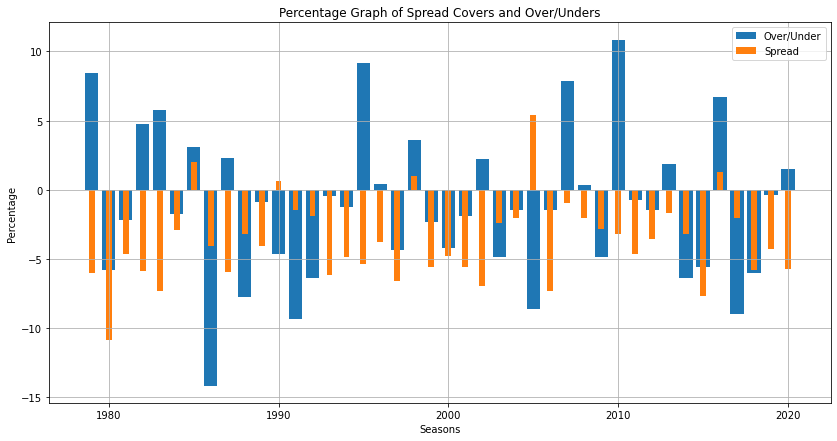

In [5]:
nump_overs = np.array(overs)
nump_unders = np.array(unders)
nump_correct = np.array(percentage_correct)

fig, ax = plt.subplots()

ax.bar(years, (nump_overs-nump_unders), label='Over/Under')
ax.bar(years, (nump_correct-50), width = 0.35, label='Spread')
plt.grid(True)
ax.set_ylabel('Percentage')
ax.set_xlabel('Seasons')
ax.set_title('Percentage Graph of Spread Covers and Over/Unders')
ax.legend()
fig.set_size_inches(14, 7)


Okay, so obviously that plot looks a little intimidating but it's quite informative so let's break it down. First, the blue bars represent the over/under percentages of each season by taking the difference between the percentage of games that ended over the projection and those that finished under. Therefore years that have a positive percentage means there was that percentage of games that were over the Over/Under projection compared to the under percentage and vice versa for years with negative percentages. Second, the orange bars represent the spread percentages of each season. This is done by first subtracting 50% from the determined value and then plotting the positive or negative result on the same plot for each year. The reason 50% is subtracted is to somewhat normalize the data and show the accuracy of the spread projection better since the goal of the creator of the projection is to make it as close to 50/50 as possible since that is also to payout. 

Now that the plot has been understood, what does it show? 

1. On average, the creators of the projections seem to have an overall percentage of over and under games very close to 50%, in fact if you average all of the years over and under percentages you find that __48.3%__ of games were over and __49.7%__ under their projections. However the variance between the seasons seems relatively high with many of the seasons having large discrepancies between each other and after calculations the standard deviation is about __5.5%__ between the years.

2. The spread data seems to be somewhat opposite as there is a consistent trend of negative percentages. This means that the creators of the projections are consistently wrong more than half the time or precisely they have historically only been correct __46.3%__ of the time on their projections. The variance of this data also seems opposite as it seems quite low and again with math to prove, the standard deviation is only __3%__.

3. Time doesn't seem to have improved consistency in Over/Under projections or accuracy of spread projections. Even in the ever increasing field of sports statistics and analytics, these seem to be a constant over the years.

Just for fun, let's see how much money you would win if you bet $100 against the spread on every game of a season. Keep in mind that up until this year, which is not included in this data, there are 256 games in the regular season plus a few playoff games.

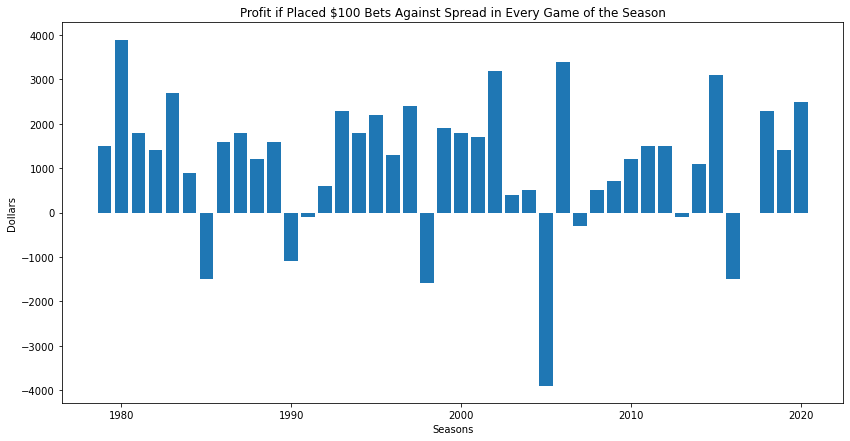

In [6]:
nump_correct2 = np.array(correct2)
nump_wrong = np.array(wrong2)

season_profit = 100*nump_wrong - 100*nump_correct2 

fig, ax = plt.subplots()

ax.bar(years, season_profit)
ax.set_ylabel('Dollars')
ax.set_xlabel('Seasons')
ax.set_title('Profit if Placed $100 Bets Against Spread in Every Game of the Season')
fig.set_size_inches(14, 7)

Of course it's proportional to the plot above but still interesting to see the relatively consistent profit of betting virtually blindly against the spread on every game. 